__Priedicting which passengers survived the Titanic shipwreck. A comparison of several [scikit-learn](https://scikit-learn.org/stable/) machine learning models.__

This project applies several different predictive models to the Kaggle [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic#evaluation) competition. It includes the description of each model tested as well as a full walk through of the data cleaning and feature selection. 

The best fit model was determined to be __RandomForestClassifier__ which yielded a Kaggle score of __79.43%__ after optimising the feature selection. 

__The Challenge__

_The sinking of the Titanic is one of the most infamous shipwrecks in history._

_On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew._

_While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others. This challenge requires a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc)._

In [1]:
# Load the Kaggle competition data
import pandas as pd
import numpy as np

# training data; passenger attributes & 'Survived' flag 
train = pd.read_csv('train.csv')  
train.head(2)

train_cp = train.copy()

In [2]:
# holdout data; identical passenger attributes, but no 'Survived' flag 
holdout = pd.read_csv('test.csv') 
holdout.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [3]:
# We have data on ~60% of all passengers 
# Which is split as 2/3rd for training and 1/3rd for the final prediction

({'Holdout Data Count':holdout.shape[0]}, 
 {'Training Data Count': train.shape[0]},
 {'Holdout vs Training Percent': 100*round(holdout.shape[0]/train.shape[0],3)},
 {'Percent of All passengers': 100*round((train.shape[0]+holdout.shape[0])/2224,3)})

({'Holdout Data Count': 418},
 {'Training Data Count': 891},
 {'Holdout vs Training Percent': 46.9},
 {'Percent of All passengers': 58.9})

# Exploring (and cleaning) the data 

Kaggle supply a [Data Dictionary](https://www.kaggle.com/c/titanic/data). The most obvious variables that appear to be very suitable for classifcation/data modelling are:

    1. Sex 
    2. Pclass (1: Upper, 2: Middle, 3: Lower) 
    3. Age (fractional if less than 1)
    4. SibSp (# of siblings / spouses aboard)
    5. Parch (# of parents / children aboard - It is noted that some children travelled with Nannys (parch=0) )
    6. Embarked (C = Cherbourg, Q = Queenstown, S = Southampton) 

The below columns will require further exploration, some may need to be excluded from the model.

    1. PassengerId (a unique identifer supplied by Kaggle - it will definitely be excluded)
    2. Fare (possibly a proxy for 'Pclass' and so may lead to overfitting)
    3. Ticket (possibly unique per passenger)   
    4. Cabin (Cabin number)
    5. Name (Format: [Surname], [Title]. [FirstName])
    
## Missing Values

In [4]:
MissingValues = pd.DataFrame([train.isnull().sum(axis=0),holdout.isnull().sum(axis=0)], 
                             index=['Training','Holding'])
MissingValues[MissingValues.columns[MissingValues.sum(axis=0)>0]]

,Age,Fare,Cabin,Embarked
Training,177.0,0.0,687.0,2.0
Holding,86.0,1.0,327.0,0.0


__Fare__ has just one missing row, in the holding data. A simple replace with the mean will have to suffice, as per the above, we may yet drop it. 

__Age__ and (especially) __Cabin__ have many missing columns. These will need be be catergorised as _Unknown_. 

In [5]:
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


__Embarked__ has only two missing rows, affecting only the training data. 

Both the Ticket No. '113572' and Cabin ID 'B28' are unique to these two individuals. 
The first character of the Cabin ID is a letter ('B'), the remainder is a number.  

Therefore the Cabin ID prefix (str[0]) can be split out and categorised. Note: For some passengers the Cabin ID suffix contains several Cabins (e.g. C23 C25 C27 - see: train["Cabin"].str[1:].dropna().value_counts() ), these will be ignored.

In [6]:
train["Cabin"].str[0].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

There is no obvious grouping for the two passengers with missing 'Embarked'. Embarked='S' is by far the most common across all passengers (644/891) and also those with a 'B' Cabin. Therefore 'S' will be used. 

In [7]:
train[train["Cabin"].str[0] == 'B']['Embarked'].value_counts()

S    23
C    22
Name: Embarked, dtype: int64

Next, define some functions to clean the above missing values and to further categorise other columns. Note: All of these functions will input/output the whole DataFrame and so the docstring shall contain only a brief description for each.

__Age__ should be expected to be a continuous variable and will need to be converted into a categorical feature instead.

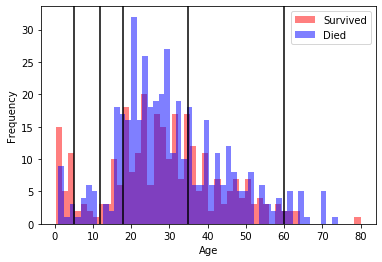

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_hist(df,column_name,v_lines=[],x_range=None):
    """Plot two histograms for a target column; 'Survived' and 'Died'
    
    Args:
      df (DataFrame): The string to search.
      column_name (str): The target column.
      v_lines (list): Suitable bins for classifications    
    """

    survived = df[df["Survived"] == 1]
    died = df[df["Survived"] == 0]
    survived[column_name].plot.hist(alpha=0.5,color='red',bins=50,range=x_range)
    died[column_name].plot.hist(alpha=0.5,color='blue',bins=50,range=x_range)
    plt.legend(['Survived','Died'])
    plt.xlabel(column_name)
    
    for v in v_lines:
        plt.axvline(v,c='black') 

    return None

plot_hist(train,"Age",v_lines=[5,12,18,35,60])

In [9]:
def clean_age(df):
    '''Group into age bins and flag the missing values.'''    
    
    df["Age"] = df["Age"].fillna(-0.5) # Min should be Zero
    cut_points = [-1,0,5,12,18,35,60,100] # The above (bounded) 'v_lines'
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df['Age_Class'] = pd.cut(df["Age"],cut_points,labels=label_names)    
    return df.drop(columns='Age')

clean_age(train).tail(5)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Class
886,887,0,2,"Montvila, Rev. Juozas",male,0,0,211536,13.00,NaN,S,Young Adult
887,888,1,1,"Graham, Miss. Margaret Edith",female,0,0,112053,30.00,B42,S,Young Adult
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,1,2,W./C. 6607,23.45,NaN,S,Missing
889,890,1,1,"Behr, Mr. Karl Howell",male,0,0,111369,30.00,C148,C,Young Adult
890,891,0,3,"Dooley, Mr. Patrick",male,0,0,370376,7.75,NaN,Q,Young Adult


In [10]:
def clean_cabin(df):
    '''Split out the first character and flag the missing values.'''   

    df["Cabin"] = df["Cabin"].str[0]
    df["Cabin"] = df["Cabin"].fillna("UKN")    
    return df

In [11]:
def clean_missing(df):
    """Clean the remaining missing Columns"""
    
    df["Fare"] = df["Fare"].fillna(df["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

## Further data categorisation

The initial hypothesis is that the __Ticket__ number will be unique per passenger. If so, it will offer only noise to the fit and will need to be dropped. 

In [12]:
print("Unique 'PassengerId' Count:\t{}\nUnique 'Ticket' Count:\t\t{}".format(
    len(train['PassengerId'].unique()),len(train['Ticket'].unique())))

largest_ticket_groups = train['Ticket'].value_counts().head(2)

print("\n{}".format(largest_ticket_groups))

Unique 'PassengerId' Count:	891
Unique 'Ticket' Count:		681

CA. 2343    7
347082      7
Name: Ticket, dtype: int64


However __Ticket__ is not only _not_ unique per passenger but it is not even unique per family. For example, Ticket 'CA. 2343' belongs to the 'Sage' family, whereas Ticket '1601' appears to be a mix of friends and family, given that the two passengers share the same Surname ('Lam'). They are not flagged as Siblings, but this is probably expected for Adult passengers, unfortunately their ages are not specified. 

We will explore the data further but may return to this point.

In [13]:
train[train['Ticket'].isin(largest_ticket_groups.index)][['Ticket','Name','SibSp','Parch','Age']].sort_values(['Ticket'])

,Ticket,Name,SibSp,Parch,Age
13,347082,"Andersson, Mr. Anders Johan",1,5,39.0
119,347082,"Andersson, Miss. Ellis Anna Maria",4,2,2.0
541,347082,"Andersson, Miss. Ingeborg Constanzia",4,2,9.0
542,347082,"Andersson, Miss. Sigrid Elisabeth",4,2,11.0
610,347082,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",1,5,39.0
813,347082,"Andersson, Miss. Ebba Iris Alfrida",4,2,6.0
850,347082,"Andersson, Master. Sigvard Harald Elias",4,2,4.0
159,CA. 2343,"Sage, Master. Thomas Henry",8,2,-0.5
180,CA. 2343,"Sage, Miss. Constance Gladys",8,2,-0.5
201,CA. 2343,"Sage, Mr. Frederick",8,2,-0.5


__Fare__ is possibly a proxy for __Pclass__ and so may lead to overfitting. However __Pclass__ has only three classifications whereas __Fare__ is a continuous variable. 

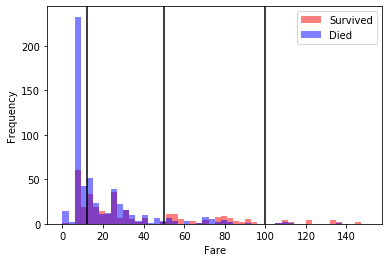

In [14]:
plot_hist(train,"Fare",v_lines=[12,50,100],x_range=(0,150))

In [15]:
def clean_fare(df):
    """Group into bins and replace the missing values."""

    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

## Inferred Attributes 

__Name__ follows the form: [Surname], [Title]. [FirstName], classified with the ticket number we can possibly group passengers into families. However __SibSp__ and __Parch__ also group passengers and families. 

Text(0.5, 0, '# per passenger')

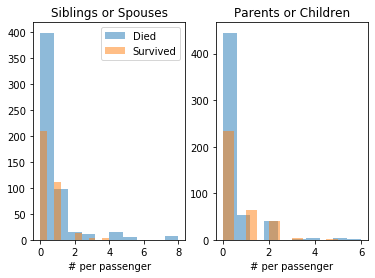

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2)

survived = train['Survived'] == True

ax1.hist(train['SibSp'][~survived], label='Died',alpha=0.5)
ax1.hist(train['SibSp'][survived], label='Survived',alpha=0.5)
ax1.legend(loc='upper right')

ax2.hist(train['Parch'][~survived], label='Died',alpha=0.5)
ax2.hist(train['Parch'][survived], label='Survived',alpha=0.5)

ax1.set_title('Siblings or Spouses')
ax2.set_title('Parents or Children')
ax1.set_xlabel('# per passenger')
ax2.set_xlabel('# per passenger')

It is clear that a passenger is much more likely to die if they did not have any siblings/spouse. The same is true for passengers that did not have any parents or children. 

The survival rate moves closer to even if a passenger has 1 or 2 of either group, whereas the survival rate for a passenger with many siblings decreases significantly. However the numbers are small and so it is likely a small handful of families where all members died. 

In [17]:
big_familes = train[(train['SibSp'] >= 4)]
big_familes['Survived'].value_counts()/big_familes['SibSp'].mean()

0    5.294118
1    0.588235
Name: Survived, dtype: float64

In [18]:
lone_travelers = train[(train['SibSp'] == 0) & (train['Parch'] == 0)]
lone_travelers['Survived'].value_counts(normalize=True)*100

0    69.646182
1    30.353818
Name: Survived, dtype: float64

A passenger is more than twice as likely to die if they were alone and signficantly more likely to die if they had a large family. 

However it was seen earlier that Ticket '1601' was shared by 7 people and even though two passengers shared the same Surname ('Lam'), neither has a non-zero __SibSp__ or __Parch__ value. These people are flagged above as alone, but this is undoubtedly untrue and so they should be classified as such. 

Text(0, 0.5, 'Group Size')

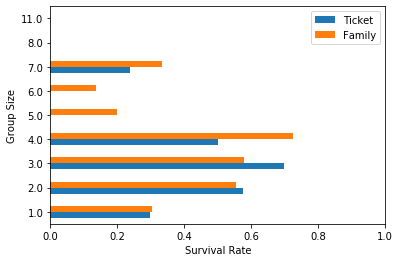

In [19]:
# Group Tickets to infer Group Size
ticket_size = train['Ticket'].value_counts().to_frame().reset_index()
ticket_size = ticket_size.rename(columns={'index':'Ticket','Ticket':'ticket_size'})
ticket_size = train.merge(ticket_size,how='left',on='Ticket')
pivot_ticket = ticket_size.pivot_table(index=['ticket_size'],values="Survived")

# Sum SibSp and Parch to infer Family Size
family_size = train[["SibSp","Parch","Survived"]].copy()
# +1 because '0' family signals lone traveler
family_size['family_size'] = family_size[["SibSp","Parch"]].sum(axis=1) + 1 
pivot_family = family_size.pivot_table(index=['family_size'],values="Survived")

# merge and reshape
total_size = pd.merge(pivot_ticket.reset_index(),pivot_family.reset_index(),suffixes=('_t','_f'),
                      left_on='ticket_size', right_on='family_size',how='outer')
total_size['size'] = total_size[['ticket_size','family_size']].max(axis=1)
total_size = total_size.set_index('size')[['Survived_t','Survived_f']].fillna(0)

# Plot
ax = total_size.rename(columns={'Survived_t':'Ticket','Survived_f':'Family'}).plot.barh(xlim=(0,1))
ax.set_xlabel('Survival Rate')
ax.set_ylabel('Group Size')

Grouping the passengers by both family size and ticket size will cause a significant overlap since it is likely that a single family will be on one ticket. 

However in addition to the aforementioned 'unrelated travellers (such as ticket '1601') the Kaggle Data dictionary does explicitly state that a child traveling with a nanny would have __Parch__=0.

Therefore both the Family size (__Parch__ + __SibSp__) and Ticket size will be used to define a single feature _Group Size_ - which will be split into three categories; 
    1. Alone (low chance of survival)
    2. Midsize (good chance of survival)
    3. Large (low chance of survival)

In [20]:
def group_size(df):
    '''Determine the size of the group to which each passenge belongs'''
    
    df_cp = df.copy()    
    
    # Group as defined by Family, +1 because '0' family signals lone traveler
    df_cp['family_size'] = df_cp[['SibSp','Parch']].sum(axis=1) + 1 

    # Group as definted by Ticket
    ticket_size = df_cp['Ticket'].value_counts().to_frame().reset_index()
    ticket_size = ticket_size.rename(columns={'index':'Ticket','Ticket':'ticket_size'})
    df_cp['ticket_size'] = pd.merge(df_cp,ticket_size,how='left',on='Ticket')['ticket_size']
    
    # Pick the largest value from each
    df_cp['max_size'] = df_cp[['family_size','ticket_size']].max(axis=1)

    # New col Group_Size, from the three bins, Alone, MidSize and Large
    df_cp.loc[df_cp['max_size'] == 1, 'Group_Size'] = 'Alone'
    df_cp.loc[df_cp['max_size'] >= 5, 'Group_Size'] = 'Large'
    df_cp.loc[((df_cp['max_size'] > 1) & (df_cp['max_size'] <= 4)), 'Group_Size'] = 'MidSize'

    # Drop helper cols and overlaps.
    return df_cp.drop(columns=['family_size','ticket_size','max_size','Ticket','SibSp','Parch'])

group_size(train)['Group_Size'].value_counts(dropna=False)+group_size(holdout)['Group_Size'].value_counts(dropna=False)

Alone      694
MidSize    519
Large       96
Name: Group_Size, dtype: int64

Each passenger's __Name__ follows the form: [Surname], [Title]. [FirstName]. We've already categorised each passenger to a group size which makes the Surname redundant. 

The __Sex__ of each passenger is only a binary classification, whereas the passenger [Title] could be used to create a more broad classification. 

This could be very useful because __Sex__ is a strong indictor of survival:

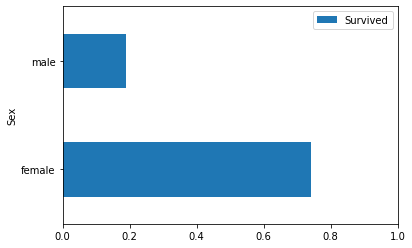

In [21]:
sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.barh(xlim=(0,1))

In [22]:
title_map = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Serivce",
    "Rev":         "Serivce",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
    }

def extract_titles(df):
    """Extract and categorize the title from the name column """

    extracted_titles = df['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)
    df['Title'] = extracted_titles.map(title_map)
  
    return df

extract_titles(holdout)['Title'].value_counts(dropna=False)

Mr         240
Miss        78
Mrs         73
Master      21
Serivce      3
Officer      2
Royalty      1
Name: Title, dtype: int64

Mr_male           517
Miss_female       184
Mrs_female        127
Master_male        40
Serivce_male       12
Officer_male        5
Royalty_male        3
Royalty_female      2
Serivce_female      1
dtype: int64

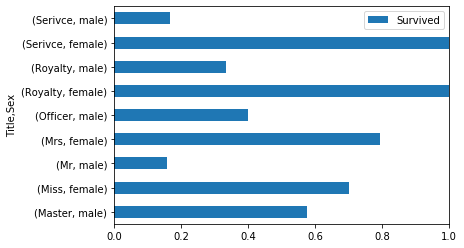

In [23]:
titles = extract_titles(train)

train_pivot = titles.pivot_table(index=["Title",'Sex'],values="Survived")
train_pivot.plot.barh(xlim=(0,1))

(titles['Title'] + '_' + titles['Sex']).value_counts()

The _Serivce_ and _Royalty_ __Title__ do not disambiguate the __Sex__ of a passenger and there is a strong split between the survival rates of each Sex within these categories. 

However because the majority of passengers do not fall into either of these categories, there is the risk of overfitting the model if the __Sex__ of each passenger in addition to the __Title__. 

Because there is only one _Serivce_female_ passenger we should not segment the passengers into such a fine category. 

From the above it is seen that >70% of all female passengers survived. It is also known (as popularised by the film _Titanic_ ) that the wealthy survived in greater numbers. For this reason it is likely that all _Female Royals_ survived the Titanic. Grouping all royals together would give the chance of survival for a female royal =60%, i.e. less than the average female passenger. There is only one (female) Royal in all of the Holdout data so the risk of overfitting is small.

In [24]:
# Rewrite/rerun extract_titles() to segment Royals 

title_map["Countess"] = "Royalty_Fe"
title_map["Dona"] = "Royalty_Fe"
title_map["Lady"] = "Royalty_Fe"

def extract_titles(df):
    """Extract and categorize the title from the name column """
    
    extracted_titles = df['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)
    df['Title'] = extracted_titles.map(title_map)
  
    df.drop(columns=['Name'],inplace=True) # Name now redundant
    df.drop(columns=['Sex'],inplace=True)  # Sex now redundant
    return df 

In [25]:
holdout_royal = holdout.copy()
holdout_royal = extract_titles(holdout_royal)
holdout_royal_id = int(holdout_royal[holdout_royal['Title'] == "Royalty_Fe"]['PassengerId'])
holdout_royal_id # as it is only a single row it will be fun to spot check this later

1306

## Final Format
Clean both data sets and create dummy columns

In [26]:
def create_dummies(df,column_name,dummy_dict):
    """Create Dummy Columns (One Hot Encoding) from a single Column"""
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    
    dummy_dict[column_name] = dummies.columns
    return df.drop(columns=[column_name]), dummy_dict

In [27]:
def full_load(df):
    df = clean_age(df)
    df = clean_cabin(df)
    df = clean_missing(df)
    df = clean_fare(df)
    df = group_size(df)    
    df = extract_titles(df)

    dummy_dict = {}
    for col in ['Pclass','Age_Class', 'Cabin', 'Fare', 'Embarked', 'Title', 'Group_Size']:
         df,dummy_dict = create_dummies(df,col,dummy_dict)
            
    return df, dummy_dict

train_pre = train.copy()
holdout_pre = holdout.copy()

In [28]:
train, dummy_dict = full_load(train)
holdout, ignore_ = full_load(holdout)

train.head(2)

,PassengerId,Survived,Pclass_1,Pclass_2,Pclass_3,Age_Class_Missing,Age_Class_Infant,Age_Class_Child,Age_Class_Teenager,Age_Class_Young Adult,...,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Title_Royalty_Fe,Title_Serivce,Group_Size_Alone,Group_Size_Large,Group_Size_MidSize
0,1,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
1,2,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [29]:
all_train_columns = train.columns.drop(['Survived','PassengerId'])
all_holdout_columns = holdout.columns.drop(['PassengerId'])
len(all_train_columns), len(all_holdout_columns)

(37, 35)

In [30]:
print( 'Columns not found in Holdout Data:  {0}'.format(all_train_columns[~all_train_columns.isin(all_holdout_columns)]))
print( 'Columns not found in Training Data: {0}'.format(all_holdout_columns[~all_holdout_columns.isin(all_train_columns)]))

Columns not found in Holdout Data:  Index(['Cabin_T', 'Title_Royalty'], dtype='object')
Columns not found in Training Data: Index([], dtype='object')


Two columns - _Cabin_T_ and _Title_Royalty_ - are found within the training data but are missing within the (smaller subset) holdout data. These are categorised fields and so they can be added with Zero for all values. 

In [31]:
holdout['Cabin_T'] = 0
holdout['Title_Royalty'] = 0

# Brute force different sklearn models using all available data 

* __KNeighborsClassifier__
       
    Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.
    
    
* __LogisticRegression__
    
    The probabilities describing the possible outcomes of a single trial are modeled using a logistic function.
    Well suited for _Binary_ data, such as _Survived_ and _Died_ classifications. 


* __RandomForestClassifier__
    
    Individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out.


* __SGDClassifier__
    
    Stochastic Gradient Descent (SGD) is a simple yet very efficient approach to fitting linear classifiers.
    Strictly speaking, SGD is merely an optimization technique and does not correspond to a specific family of machine learning models, it is only a way to _train_ a model.
    
    
Using __GridSearchCV__ each model will be fit with numerous _hyperparameters_ thereby selecting the best version of each model.

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore') # Deprecation Warnings

# the various models and their hyperparameters
sklearn_models = {        
    "LogisticRegression": {
        "estimator": LogisticRegression(random_state=17),
        "hyperparameters":
            {
                "solver": ["newton-cg", "lbfgs", "liblinear"],
            }
    },
    "KNeighborsClassifier": {            
        "estimator": KNeighborsClassifier(),
        "hyperparameters":
            {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
            }
    }, 
    "RandomForestClassifier":
    {
        "name": "RandomForestClassifier",
        "estimator": RandomForestClassifier(random_state=17),
        "hyperparameters":
            {
                "n_estimators": [6, 9, 12, 15, 20 ],
                "criterion": ["entropy", "gini"],
                "max_depth": [5, 10, 15, 20, 25],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf" : [1, 5, 8],
                "min_samples_split": [2, 3, 5],
            }
    },                
    "SGDClassifier": {
        "estimator": SGDClassifier(random_state=17),
        "hyperparameters":
            {
                "eta0": [1],
                "learning_rate": ["constant", "optimal", "invscaling", "adaptive"],
            }
    },           
}
    
def select_model(df,features,model_choice=''):
    '''loop over various models'''
    
    all_X = df[features]
    all_y = df['Survived']    
    
    models = sklearn_models
    
    if model_choice != '':
        models = {model_choice : models[model_choice]}
    
    for model_name, model in models.items():
        print( 'model: {0}'.format(model_name) )
        
        grid = GridSearchCV(model['estimator'],param_grid=model['hyperparameters'], cv=10)
        grid.fit(all_X,all_y)

        model['best_score'] = grid.best_score_
        model['best_params']= grid.best_params_
        model['best_model'] = grid.best_estimator_

        print( '  score:  {:.2f}'.format(grid.best_score_*100.))
        print( '  params: {0}'.format(grid.best_params_))

    return models

all_columns = train.columns.drop(['Survived','PassengerId'])
best_models = select_model(train,all_columns)

model: LogisticRegression
  score:  82.49
  params: {'solver': 'newton-cg'}
model: KNeighborsClassifier
  score:  82.83
  params: {'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
model: RandomForestClassifier
  score:  83.61
  params: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 15}
model: SGDClassifier
  score:  82.15
  params: {'eta0': 1, 'learning_rate': 'adaptive'}


__RandomForestClassifier__ yielded the best fit. This will be the first to be submitted to Kaggle.

In [33]:
def save_submission_file(model,features,filename):
    '''Create a .csv file in the required format'''
    
    holdout_predictions = model['best_model'].predict(holdout[features])
    
    # Kaggle expects two Columns
    submission = pd.DataFrame({
                    'PassengerId': (holdout['PassengerId']),
                    'Survived': holdout_predictions, })
                     
    submission.to_csv(filename,index=False)
    return submission

In [34]:
submission = save_submission_file(best_models['RandomForestClassifier'],all_columns,'JJ_Kaggle_RFC_All_Features.csv')
submission[submission['PassengerId'] == holdout_royal_id ]

,PassengerId,Survived
414,1306,1


In [35]:
 submission.shape, all_columns.shape

((418, 2), (37,))

# Optimised Features

The above __RandomForestClassifier__ model yielded a _Kaggle Score_ of 76.56%. This is below the predicted score of 83.28%. 

However this is not too suprising. All of the available (37) columns were used in the model fitting and therefore there must have been overlapping features causing the model to overfit. 

Targeting a subset of features is likely to create a better _real world_ fit. Numerous dummy features were created, but we can infer each dummy feature from all other dummy features - i.e. Group Size Alone == NOT(MidSize + Large) - as the model does not know that these are mutually dependent fields, they are candidates for the cause of any overfit. 

Overlapping features can be expected to strongly correlate with each other. The below is a heatmap of the correlation for each:

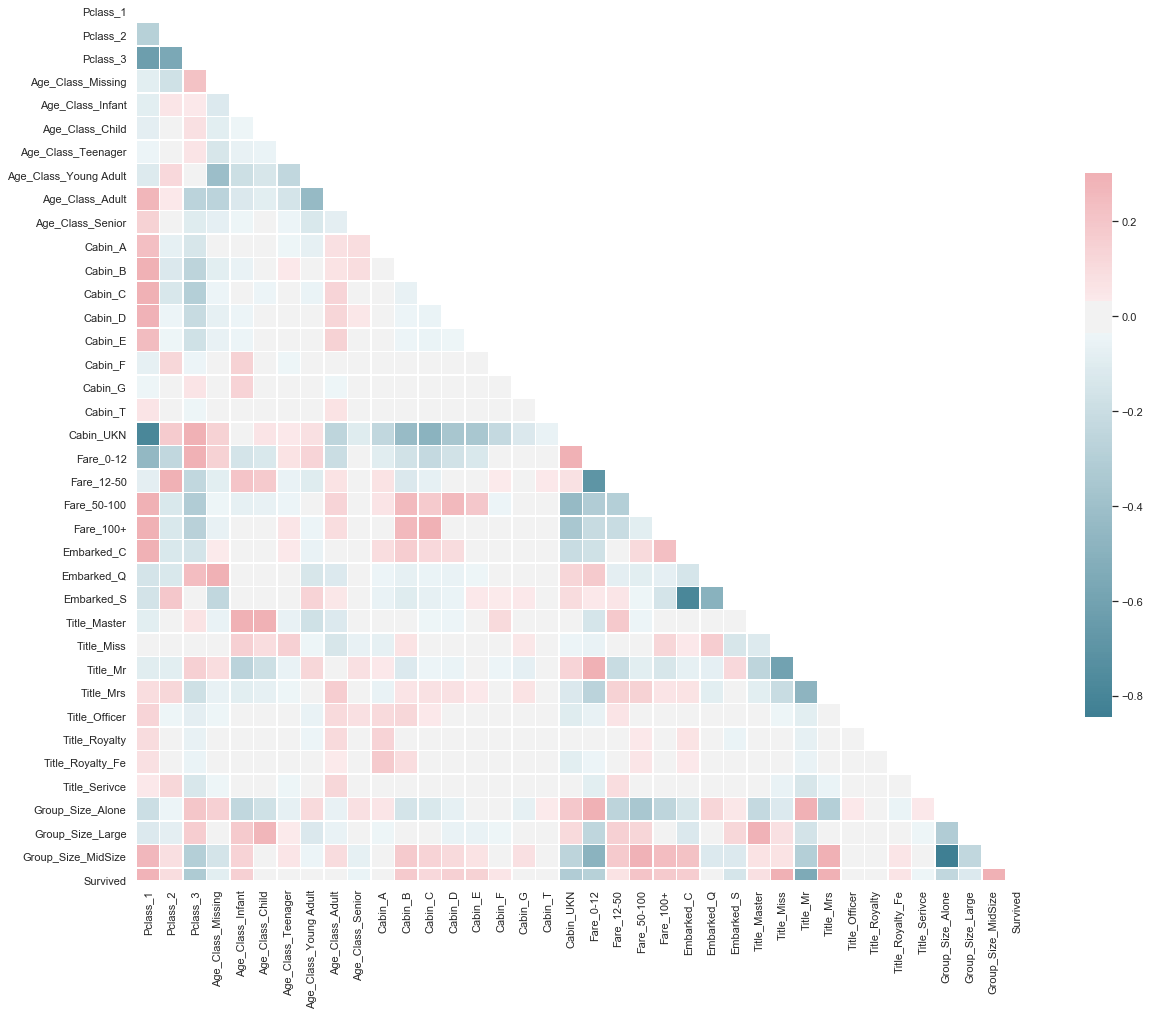

In [36]:
import seaborn as sns

correlation_cols = list(all_columns)
correlation_cols.append('Survived')

corr = train[correlation_cols].corr()

sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5})

Drop one Dummy Feature from each parent feature. Choosing the dummy feature that correlates least well with __Survived__:

In [37]:
corr = train[correlation_cols].corr()['Survived']

new_selected_cols = all_columns.copy()

for parent_col in dummy_dict:
    dummy_cols = dummy_dict[parent_col]
    least_corr = corr[dummy_cols].abs().idxmin(axis=1)
    
    new_selected_cols = new_selected_cols.drop(least_corr)    
    print("Dropping column '{0}, least well correlated from dummy parent set: '{1}'".format(least_corr, parent_col)) 

print("\nInitial count: {0}, New feature count: {1}".format(all_columns.shape[0], new_selected_cols.shape[0]))

Dropping column 'Pclass_2, least well correlated from dummy parent set: 'Pclass'
Dropping column 'Age_Class_Young Adult, least well correlated from dummy parent set: 'Age_Class'
Dropping column 'Cabin_G, least well correlated from dummy parent set: 'Cabin'
Dropping column 'Fare_12-50, least well correlated from dummy parent set: 'Fare'
Dropping column 'Embarked_Q, least well correlated from dummy parent set: 'Embarked'
Dropping column 'Title_Officer, least well correlated from dummy parent set: 'Title'
Dropping column 'Group_Size_Large, least well correlated from dummy parent set: 'Group_Size'

Initial count: 37, New feature count: 30


Refit the model using the subset of 30 features. 

Note: other features still correlate well to each other and may suggest cause for overfitting - e.g. __Cabin_UKN__ is very well correlated to __Pcalss_1__ (perhaps 1st class tickets do not define Cabins) and yet both of these remain in the new subset. We may return to this later. 

In [38]:
best_models = select_model(train,new_selected_cols)

model: LogisticRegression
  score:  82.49
  params: {'solver': 'newton-cg'}
model: KNeighborsClassifier
  score:  82.72
  params: {'algorithm': 'brute', 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
model: RandomForestClassifier
  score:  83.16
  params: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 20}
model: SGDClassifier
  score:  81.82
  params: {'eta0': 1, 'learning_rate': 'invscaling'}


In [39]:
submission = save_submission_file(best_models['RandomForestClassifier'],new_selected_cols,'JJ_Kaggle_RFC_Reduced_Features_30.csv')
submission[submission['PassengerId'] == holdout_royal_id ]

,PassengerId,Survived
414,1306,1


The score has improved from 76.56% using all features, increasing to 77.99% using the reduced features - or rather, 3/209 (note: not 418 as per Kaggle) additional correctly made predictions. Optimising the features further may add improvements. 
# Automated feature selection via RFECV

The scikit-learn RFECV will use recursive feature elimination (RFE) to select features by recursively considering smaller and smaller sets of features. The features are recursively pruned until the desired number of features to select is eventually reached.

In [40]:
from sklearn.feature_selection import RFECV 

def select_features(df,model_choice,pre_screen_cols=[]):
    '''Use sklearn.feature_selection (RFECV)
    Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), 
    recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller 
    sets of features.'''
    
    # remove non-numeric columns (should be Zero)
    df = df.select_dtypes(exclude=['object','category'])
    
    # get feature columns; exclude unique 'PassengerId' and target col     
    all_X = df.iloc[:,~df.columns.isin(['Survived','PassengerId'])]
    all_y = df['Survived']
    
    if len(pre_screen_cols):
        all_X = all_X[pre_screen_cols]
    
    selector = RFECV(model_choice,cv=20)
    
    selector.fit(all_X,all_y)
    best_columns = all_X.columns[selector.support_]
    all_columns  = all_X.columns
    print("Best Features \n"+"-"*12+"\n{}\n".format(list(best_columns)))

    print("Best Features selection has excluded {0} features from full set of {1} columns - {2} features remain\n".format(
        all_columns.shape[0]-best_columns.shape[0], all_columns.shape[0], best_columns.shape[0]))

    print("Excluded Features:\n"+"-"*12+"\n{}\n".format(list(all_columns[~all_columns.isin(best_columns)])))
                        
    return best_columns #, all_X, all_y, df.copy() 

In [41]:
best_columns_rfc = select_features(train, RandomForestClassifier(random_state=17))

Best Features 
------------
['Pclass_3', 'Cabin_UKN', 'Fare_0-12', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Group_Size_MidSize']

Best Features selection has excluded 30 features from full set of 37 columns - 7 features remain

Excluded Features:
------------
['Pclass_1', 'Pclass_2', 'Age_Class_Missing', 'Age_Class_Infant', 'Age_Class_Child', 'Age_Class_Teenager', 'Age_Class_Young Adult', 'Age_Class_Adult', 'Age_Class_Senior', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Fare_12-50', 'Fare_50-100', 'Fare_100+', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Officer', 'Title_Royalty', 'Title_Royalty_Fe', 'Title_Serivce', 'Group_Size_Alone', 'Group_Size_Large']



The RFECV feature selection has significantly reduced the number of features from 37 to 7 features. 

Note: No difference in feature selection if we use the default model or chose the best fit model to then determine the best feature selection:

In [42]:
best_columns_rfc = select_features(train, best_models['RandomForestClassifier']['estimator'])

Best Features 
------------
['Pclass_3', 'Cabin_UKN', 'Fare_0-12', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Group_Size_MidSize']

Best Features selection has excluded 30 features from full set of 37 columns - 7 features remain

Excluded Features:
------------
['Pclass_1', 'Pclass_2', 'Age_Class_Missing', 'Age_Class_Infant', 'Age_Class_Child', 'Age_Class_Teenager', 'Age_Class_Young Adult', 'Age_Class_Adult', 'Age_Class_Senior', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Fare_12-50', 'Fare_50-100', 'Fare_100+', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Officer', 'Title_Royalty', 'Title_Royalty_Fe', 'Title_Serivce', 'Group_Size_Alone', 'Group_Size_Large']



Next we produce a final workflow to determine the best fit features for each model (via RFECV). Then find the best version of that model (via GridSearchCV) and generate the final results.

In [43]:
def fit_and_submit(model_name,filename):
    '''Run a mode through select_features() to obtain the optimised column selection
    and then optimise the model itself via select_model()'''
    
    target_model = sklearn_models[model_name]['estimator']
    
    # find best fit features. 
    best_columns = select_features(train, target_model)
        
    # get the best version of this model using the optimised features
    best_models = select_model(train, best_columns, model_name)    
    best_model  = best_models[model_name]
    
    submission  = save_submission_file(best_model,best_columns,filename)
        
    print('\nholdout_royal_id:\n{}'.format(submission[submission['PassengerId'] == holdout_royal_id]))
    
    assert( submission.shape[0] == 418 )
    
    return best_columns

In [44]:
best_columns_rfc = fit_and_submit('RandomForestClassifier','JJ_Kaggle_RFC_RFECV.csv')

Best Features 
------------
['Pclass_3', 'Cabin_UKN', 'Fare_0-12', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Group_Size_MidSize']

Best Features selection has excluded 30 features from full set of 37 columns - 7 features remain

Excluded Features:
------------
['Pclass_1', 'Pclass_2', 'Age_Class_Missing', 'Age_Class_Infant', 'Age_Class_Child', 'Age_Class_Teenager', 'Age_Class_Young Adult', 'Age_Class_Adult', 'Age_Class_Senior', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Fare_12-50', 'Fare_50-100', 'Fare_100+', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Officer', 'Title_Royalty', 'Title_Royalty_Fe', 'Title_Serivce', 'Group_Size_Alone', 'Group_Size_Large']

model: RandomForestClassifier
  score:  83.50
  params: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 20}

holdout_royal_id:
     PassengerId  Survived
414         1306         1


Using just the 7 best fit features yields a new Kaggle Score of 79.43% - which is a further 3 additional correct predictions. 

Running the same optimised rfc features through the the select_model() did not improve RandomForestClassifier() estimated score in comparison to the manaully reduced features. However it improved the estimated score for the KNeighborsClassifier() to almost a tie - and reduced the LogisticRegression() score. 

As a final test, each model should be fit with the best features that are derived for each specific model. From these optimsed features the best version (set of hyperparameters) for each model will then be chosen.

In [45]:
print('LogisticRegression: -----------------------\n')
best_columns_lr  = fit_and_submit('LogisticRegression', 'JJ_Kaggle_LR_RFECV.csv')

print('\n\nSGDClassifier: -----------------------\n')
best_columns_sgd = fit_and_submit('SGDClassifier', 'JJ_Kaggle_SGD_RFECV.csv')

LogisticRegression: -----------------------

Best Features 
------------
['Cabin_UKN', 'Title_Master', 'Title_Miss', 'Title_Mrs', 'Group_Size_Large']

Best Features selection has excluded 32 features from full set of 37 columns - 5 features remain

Excluded Features:
------------
['Pclass_1', 'Pclass_2', 'Pclass_3', 'Age_Class_Missing', 'Age_Class_Infant', 'Age_Class_Child', 'Age_Class_Teenager', 'Age_Class_Young Adult', 'Age_Class_Adult', 'Age_Class_Senior', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Fare_0-12', 'Fare_12-50', 'Fare_50-100', 'Fare_100+', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Mr', 'Title_Officer', 'Title_Royalty', 'Title_Royalty_Fe', 'Title_Serivce', 'Group_Size_Alone', 'Group_Size_MidSize']

model: LogisticRegression
  score:  82.94
  params: {'solver': 'newton-cg'}

holdout_royal_id:
     PassengerId  Survived
414         1306         0


SGDClassifier: -----------------------

Best Features 
------------
['Age_

KNeighbors isn't supported within the RFECV framework (See [discussion](https://github.com/scikit-learn/scikit-learn/issues/6920)). 

Instead try use the best version from the prior feature selections:

In [46]:
RFECV_cols = {
    "Reduced_Features": new_selected_cols,
    "RFC_Features": best_columns_rfc,
    "LR_Features": best_columns_lr,
    "SGD_Features": best_columns_sgd,    
}

best_KN_model = {'best_score':-1}
best_KN_columns = []
best_KN_desc = ''

for feature_desc in RFECV_cols:
    target_KN_features = RFECV_cols[feature_desc]
    print('\n\nFitting {0} ({1} features): -----------------------'.format(feature_desc,len(target_KN_features)))
        
    target_KN_models = select_model(train,target_KN_features,model_choice='KNeighborsClassifier')
    target_KN_model  = target_KN_models['KNeighborsClassifier']
        
    if target_KN_model['best_score'] > best_KN_model['best_score']:
        print( 'New best KNeighborsClassifier score: {:.2f}'.format(100*target_KN_model['best_score']))
        best_KN_model = target_KN_model.copy()
        best_KN_columns = target_KN_features.copy()
        best_KN_desc = feature_desc



Fitting Reduced_Features (30 features): -----------------------
model: KNeighborsClassifier
  score:  82.72
  params: {'algorithm': 'brute', 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
New best KNeighborsClassifier score: 82.72


Fitting RFC_Features (7 features): -----------------------
model: KNeighborsClassifier
  score:  83.39
  params: {'algorithm': 'brute', 'n_neighbors': 19, 'p': 1, 'weights': 'distance'}
New best KNeighborsClassifier score: 83.39


Fitting LR_Features (5 features): -----------------------
model: KNeighborsClassifier
  score:  83.39
  params: {'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


Fitting SGD_Features (14 features): -----------------------
model: KNeighborsClassifier
  score:  83.61
  params: {'algorithm': 'kd_tree', 'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}
New best KNeighborsClassifier score: 83.61


In [47]:
print('using {0} features from {1} that yielded best KNeighborsClassifier score: {2:.2f}'.format(
    len(best_KN_columns), best_KN_desc, 100*best_KN_model['best_score']))
submission = save_submission_file(best_KN_model,best_KN_columns,'JJ_Kaggle_KN_'+ best_KN_desc + '.csv')
submission[submission['PassengerId'] == holdout_royal_id ]

using 14 features from SGD_Features that yielded best KNeighborsClassifier score: 83.61


,PassengerId,Survived
414,1306,1


# Summary and final scores

Kaggle supply a [How am I doing with my score](https://www.kaggle.com/pliptor/how-am-i-doing-with-my-score/report) for this challenge. 

With a score of 79.43% the _RandomForestClassifier (RFECV)_ model beats many of the more vanila models - including the closet comparion: _Gender + Class + FamilySize + Age using Decision Tree_ (Score: 78.95%).

| Position | Model | Predicted Score | Kaggle Score | Correct Predictions (out of 209) | HoldOut Royal
| --- | --- | --- | --- | --- | --- | 
| 1 | RandomForestClassifier (RFECV) | 83.50 | 79.43 | 166 | Survived
| 2 | LogisticRegression (RFECV) | 82.94 | 78.95 | 165 | Died
| 3 | SGDClassifier (RFECV) | 82.27 | 77.99 | 163 | Survived
| - | RandomForestClassifier (Reduced Features) | 83.50 | 77.99 | 163 | Survived
| - | KNeighborsClassifier (SGD RFECV) | 83.61 | 77.99 | 163 | Survived
| 6 | RandomForestClassifier (All Features) | 83.61 | 76.56 | 160 | Survived

Interestingly the estimated score for the final _RandomForestClassifier (RFECV)_ model did not beat the estimated score for the initial _RandomForestClassifier (All Features)_ model. However we did expect this model to overfit and so this should not be a suprise. 

In 2nd place _LogisticRegression (RFECV)_ was 1 prediction short of tying for 1st place but yielded a much tighter score spread (estimated score vs final score) than did _RandomForestClassifier (RFECV)_. This was also the only model that predicted the death of the _holdout_royal_id_ (see below).

_KNeighborsClassifier (SGD RFECV)_ was tied 3rd for the final score but produced a much wider score spread. kNN requires that the features are properly scaled. As all features were converted to dummy categories further emphasis on scaling may improve this discrepancy. 

## holdout_royal_id 
This was the single _royal female_ passenger in the holdout data. Only the __LogisticRegression__ model predicted her death...

In [48]:
holdout_pre[holdout_pre['PassengerId'] == holdout_royal_id ]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C105,C,Royalty


[Doña Fermina Oliva y Ocana](https://www.encyclopedia-titanica.org/titanic-survivor/fermina-oliva-y-ocana.html), 39, was born on 12 October 1872, in Madrid, Spain.
She boarded the Titanic at Cherbourg as maid to Mrs Victor de Satode Peñasco y Castellana.
__They were rescued in lifeboat 8.__
She died May 28, 1969 in Spain having never married. 



RandomForestClassifier beat LogisticRegression by only one prediction. However, as dicussed in the Kaggle competition webpage, the scoring of the holdout data is performed on only half (209/418) passengers. 

Therefore Doña Fermina Oliva y Ocana may not be the reason that the LogisticRegression model didn't tie with the RandomForestClassifier model (or actually beat it, since the LR model had the tighter score spread). However it does highlight a interesting starting point for model refinement and to see where else LogisticRegression and RandomForestClassifier diverged. 